In [1]:
"""
credits to 
1. https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
2. https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8
3. https://colab.research.google.com/drive/1ExKu5QxKxbeO7QnVGQx6nzFaGxz0FDP3?usp=sharing#scrollTo=nqKLmvRJVnc3
"""
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
from tqdm import tqdm
import imageio

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

# helper functions
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
outputs_dir = 'outputs'
models_dir = 'models'
for dirpath in [outputs_dir, models_dir]:
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [2]:
mnist = FashionMNIST(root='./db', train=True, download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
batch_size = 64
data_loader = DataLoader(mnist, batch_size, shuffle=False)

# Visualize the datasets

labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, 

Sandal, Sandal, T-shirt/Top, Ankle Boot, Sandal, Sandal, Sneaker, Ankle Boot, 

Trouser, T-shirt/Top, Shirt, Coat, Dress, Trouser, Coat, Bag, 

Coat, Dress, T-shirt/Top, Pullover, Coat, Coat, Sandal, Dress, 

Shirt, Shirt, T-shirt/Top, Bag, Sandal, Pullover, Trouser, Shirt, 

Shirt, Sneaker, Ankle Boot, Sandal, Ankle Boot, Pullover, Sneaker, Dress, 

T-shirt/Top, Dress, Dress, Dress, Sneaker, Pullover, Pullover, Shirt, 

Shirt, Bag, Dress, Dress, Sandal, T-shirt/Top, Sandal, Sandal, 



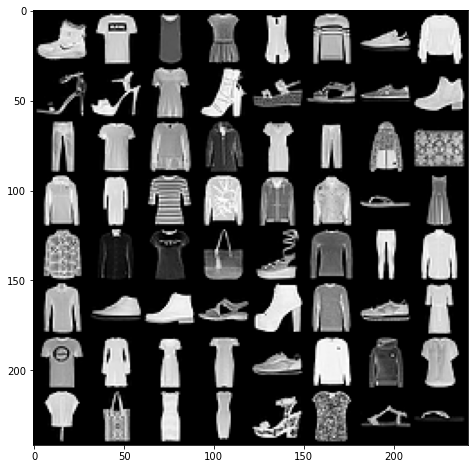

In [3]:
batch = next(iter(data_loader))
images, labels = batch
original_images = [denorm(img) for img in images]
grid = torchvision.utils.make_grid(original_images, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")
    if (i+1) % 8 == 0:
        print("\n")

# Create the generator and discriminator 

1. The **generator** constructs a fake image from a random vector.
2. The **discriminator** is a simple classifier that tries to distinguish between fake and real images.

In [4]:
latent_size = 128
image_size = 784
hidden_size = 256

class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
Image(url= "https://miro.medium.com/max/2050/1*ypsvQH7kvtI2BhzR2eT_Sw.png", width=512, height=256)

**Why Tanh?**
```
The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling.
```

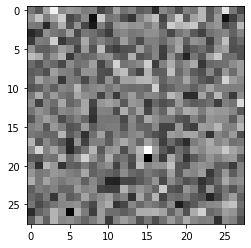

In [6]:
G = Generator(latent_size, hidden_size, image_size)
fake_img = G(torch.randn(1, latent_size))
fake_img_original_scale = denorm(fake_img.reshape((-1, 28,28)).detach())
plt.imshow(fake_img_original_scale[0], cmap='gray');

In [7]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
D = Discriminator(image_size)
D(fake_img), D(mnist[0][0].reshape((1, 784)))

(tensor([[0.5050]], grad_fn=<SigmoidBackward>),
 tensor([[0.5381]], grad_fn=<SigmoidBackward>))

# Train the GAN

In [9]:
batch_size = 512; num_epochs = 200
latent_size = 128; image_size = 784; hidden_size = 256; sample_size=64
data_loader = DataLoader(mnist, batch_size, shuffle=True)
total_step = len(data_loader)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
losses_g, losses_d, real_scores, fake_scores, images = [], [], [], [], []
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# function to create the noise vector
def create_noise(sample_size, latent_size):
    return torch.randn(sample_size, latent_size).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)
# -------------------- choose loss and optimizers ---------------------
generator = Generator(latent_size, hidden_size, image_size).to(device)
discriminator = Discriminator(image_size).to(device)
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [10]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    score_real = output_real
    
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    score_fake = output_fake
    
    total_loss = loss_real + loss_fake

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    
    return total_loss, score_real, score_fake

In [11]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss    

In [ ]:
# create the noise vector
torch.manual_seed(444)
noise = create_noise(sample_size, latent_size)

for epoch in range(num_epochs):
    loss_g = 0.0
    loss_d = 0.0
    rs = 0.0
    fs = 0.0
    for bi, data in enumerate(data_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        
        # train the discriminator network
        data_fake = generator(create_noise(b_size, latent_size)).detach()
        data_real = image
        total_loss, score_real, score_fake= train_discriminator(optim_d, data_real, data_fake)
        loss_d += total_loss
        rs += score_real.mean().item()
        fs += score_fake.mean().item()        
        
        # train the generator network
        data_fake = generator(create_noise(b_size, latent_size))
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    real_score = rs / bi
    fake_score = fs / bi
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    print(f"Epoch {epoch+1} of {num_epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}, D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}")
    if epoch in [50, 150]:
        torch.save(generator.state_dict(), f'models/{epoch}_generator.pth')
        torch.save(discriminator.state_dict(), f'models/{epoch}_discriminator.pth')

print('DONE TRAINING')
torch.save(generator.state_dict(), 'models/generator.pth')
torch.save(discriminator.state_dict(), 'models/discriminator.pth')

Epoch 1 of 200
Generator loss: 1.44446099, Discriminator loss: 0.73340911, D(x): 0.86, D(G(z)): 0.40
Epoch 2 of 200
Generator loss: 3.38782072, Discriminator loss: 0.14183493, D(x): 0.97, D(G(z)): 0.09
Epoch 3 of 200
Generator loss: 3.16476202, Discriminator loss: 0.24203689, D(x): 0.95, D(G(z)): 0.14
Epoch 4 of 200
Generator loss: 4.62926054, Discriminator loss: 0.11133700, D(x): 0.98, D(G(z)): 0.07
Epoch 5 of 200
Generator loss: 3.99895239, Discriminator loss: 0.06379151, D(x): 0.99, D(G(z)): 0.04
Epoch 6 of 200
Generator loss: 3.49614668, Discriminator loss: 0.13873844, D(x): 0.97, D(G(z)): 0.08
Epoch 7 of 200
Generator loss: 5.06070089, Discriminator loss: 0.06066311, D(x): 0.99, D(G(z)): 0.03
Epoch 8 of 200
Generator loss: 4.92799664, Discriminator loss: 0.04701178, D(x): 0.99, D(G(z)): 0.02
Epoch 9 of 200
Generator loss: 5.29653358, Discriminator loss: 0.04873415, D(x): 0.99, D(G(z)): 0.02
Epoch 10 of 200
Generator loss: 5.91631699, Discriminator loss: 0.04251591, D(x): 1.00, D(G

In [ ]:
# save the generated images as GIF file
to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')